In [32]:
import h5py
import numpy as np

mat_path = r'E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\mat files data\AE_ALL.mat'

class_map = {
    'BF': 'BF',
    'GF': 'GF',
    'TF': 'BFI',   
    'N': 'NI'      
}
channel_to_use = 0  # use only the first channel (index 0)

ae_data = {}

with h5py.File(mat_path, 'r') as mat_file:
    ae_all = mat_file['AE_ALL']
    
    for cls in class_map:
        print(f"Loading class: {cls}")
        cls_refs = ae_all[cls]  # shape (4,), object references
        
        # Dereference the object
        ref = cls_refs[channel_to_use][0]
        dataset = mat_file[ref]
        
        # Convert to numpy array
        signal = np.array(dataset)
        ae_data[cls] = signal
        
        print(f"{cls}: Channel {channel_to_use} | shape = {signal.shape}")


Loading class: BF
BF: Channel 0 | shape = (1000000, 40)
Loading class: GF
GF: Channel 0 | shape = (1000000, 40)
Loading class: TF
TF: Channel 0 | shape = (1000000, 40)
Loading class: N
N: Channel 0 | shape = (1000000, 40)


In [33]:
def segment_signal(signal, frame_size=10000, step_size=10000):
    num_samples, num_channels = signal.shape
    segments = []
    
    for start in range(0, num_samples - frame_size + 1, step_size):
        end = start + frame_size
        segment = signal[start:end, :]  # shape: (frame_size, 40)
        segments.append(segment)
    
    return np.array(segments)  # shape: (num_frames, frame_size, 40)

# Segment all classes and store in a new dictionary
segmented_data = {}

for cls, signal in ae_data.items():
    frames = segment_signal(signal, frame_size=10000, step_size=10000)
    segmented_data[cls] = frames
    print(f"{cls}: Segmented into {frames.shape[0]} frames, shape per frame: {frames.shape[1:]}")


BF: Segmented into 100 frames, shape per frame: (10000, 40)
GF: Segmented into 100 frames, shape per frame: (10000, 40)
TF: Segmented into 100 frames, shape per frame: (10000, 40)
N: Segmented into 100 frames, shape per frame: (10000, 40)


In [34]:
import pywt

def denoise_frame_wavelet(frame, wavelet='db4', level=3):
    denoised = np.zeros_like(frame)
    
    for ch in range(frame.shape[1]):
        # DWT
        coeffs = pywt.wavedec(frame[:, ch], wavelet, level=level)
        
        # Estimate threshold using Universal Threshold
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(len(frame)))
        
        # Soft thresholding on detail coefficients
        coeffs_thresh = [coeffs[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
        
        # Inverse DWT
        denoised[:, ch] = pywt.waverec(coeffs_thresh, wavelet)[:frame.shape[0]]
    
    return denoised


In [35]:
denoised_data = {}

for cls, frames in segmented_data.items():
    denoised_frames = np.array([denoise_frame_wavelet(frame) for frame in frames])
    denoised_data[cls] = denoised_frames
    print(f"{cls}: Denoised {denoised_frames.shape[0]} frames.")


BF: Denoised 100 frames.
GF: Denoised 100 frames.
TF: Denoised 100 frames.
N: Denoised 100 frames.


In [36]:
def compute_frame_energy(frame):
    # Calculate energy across all channels
    return np.sum(frame**2)

def select_burst_frames(denoised_frames, threshold_ratio=0.5):
    energies = np.array([compute_frame_energy(f) for f in denoised_frames])
    
    # Define threshold (e.g., keep top 50% energetic frames)
    threshold = np.percentile(energies, 100 * (1 - threshold_ratio))
    
    # Select frames with energy above threshold
    selected = denoised_frames[energies >= threshold]
    
    return selected, energies, threshold


In [37]:
burst_selected_data = {}
burst_info = {}

for cls, frames in denoised_data.items():
    selected, energies, threshold = select_burst_frames(frames, threshold_ratio=0.5)
    burst_selected_data[cls] = selected
    burst_info[cls] = {
        'total': len(frames),
        'selected': len(selected),
        'threshold': threshold
    }
    print(f"{cls}: Selected {len(selected)} burst frames out of {len(frames)} (threshold = {threshold:.2e})")


BF: Selected 50 burst frames out of 100 (threshold = 4.40e+03)
GF: Selected 50 burst frames out of 100 (threshold = 5.59e+02)
TF: Selected 50 burst frames out of 100 (threshold = 5.78e+03)
N: Selected 50 burst frames out of 100 (threshold = 5.35e+03)


In [38]:
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch

def extract_features_from_frame(frame):
    features = []

    for ch in range(frame.shape[1]):
        signal = frame[:, ch]

        # Time Domain Features
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        rms_val = np.sqrt(np.mean(signal**2))
        peak_val = np.max(np.abs(signal))
        skewness = skew(signal)
        kurt = kurtosis(signal)
        crest_factor = peak_val / rms_val if rms_val != 0 else 0

        # Frequency Domain Features (using Welch PSD)
        freqs, psd = welch(signal, fs=1e6, nperseg=1024)
        spectral_energy = np.sum(psd)
        spectral_centroid = np.sum(freqs * psd) / np.sum(psd)

        # Statistical Features
        ent = entropy(np.abs(signal))
        mad = np.median(np.abs(signal - np.median(signal)))
        iqr = np.percentile(signal, 75) - np.percentile(signal, 25)

        # Append all features for this channel
        features.extend([
            mean_val, std_val, rms_val, peak_val,
            skewness, kurt, crest_factor,
            spectral_energy, spectral_centroid,
            ent, mad, iqr
        ])

    return features


In [39]:
import pandas as pd

all_features = []
all_labels = []

for cls, frames in burst_selected_data.items():
    for frame in frames:
        feat = extract_features_from_frame(frame)
        all_features.append(feat)
        all_labels.append(cls)

# Convert to DataFrame
feature_df = pd.DataFrame(all_features)
feature_df['Label'] = all_labels

print("Feature extraction complete. Shape:", feature_df.shape)
feature_df.head()


Feature extraction complete. Shape: (200, 481)


,0,1,2,3,4,5,6,7,8,9,...,471,472,473,474,475,476,477,478,479,Label
0,0.001428,0.119163,0.119172,0.647373,-0.045152,4.553338,5.432271,0.000017,19526.188669,8.689768,...,0.851746,0.063780,4.812817,6.411584,0.000016,19957.546453,8.728084,0.057556,0.115035,BF
1,0.001340,0.090262,0.090272,0.557299,-0.454117,5.378091,6.173572,0.000009,19957.931908,8.758681,...,0.554541,-0.265559,3.069037,5.207726,0.000012,20502.589356,8.795951,0.050553,0.100927,BF
2,0.001392,0.077913,0.077925,0.476550,-0.204651,3.585575,6.115466,0.000006,20435.601227,8.738742,...,0.491048,-0.114266,4.815843,5.392053,0.000009,21270.351186,8.678425,0.034340,0.069046,BF
3,0.001015,0.092586,0.092591,0.538687,-0.371114,5.155318,5.817911,0.000008,20153.555013,8.732886,...,0.699688,-0.118046,5.983966,5.477957,0.000018,21075.946835,8.648951,0.045249,0.090232,BF
4,0.001416,0.106262,0.106272,0.715272,0.006337,7.338358,6.730587,0.000012,19098.437568,8.671983,...,0.798570,0.085823,7.454610,6.981545,0.000013,18051.539547,8.667283,0.041386,0.082314,BF


In [40]:
feature_df.shape

(200, 481)

In [41]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Separate features and labels
X = feature_df.drop('Label', axis=1).values
y = feature_df['Label'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2_mu = nn.Linear(128, latent_dim)
        self.fc2_logvar = nn.Linear(128, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 128)
        self.fc4 = nn.Linear(128, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2_mu(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [43]:
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [44]:
vae = VAE(input_dim=X_scaled.shape[1], latent_dim=15)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# Training loop
vae.train()
epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        x_batch = batch[0]
        optimizer.zero_grad()
        recon, mu, logvar = vae(x_batch)
        loss = vae_loss(recon, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.2f}")


Epoch 1/100 - Loss: 99920.62
Epoch 2/100 - Loss: 85438.58
Epoch 3/100 - Loss: 67716.75
Epoch 4/100 - Loss: 58481.04
Epoch 5/100 - Loss: 52661.01
Epoch 6/100 - Loss: 48290.49
Epoch 7/100 - Loss: 45715.60
Epoch 8/100 - Loss: 44507.49
Epoch 9/100 - Loss: 43648.65
Epoch 10/100 - Loss: 42731.01
Epoch 11/100 - Loss: 41909.60
Epoch 12/100 - Loss: 41073.62
Epoch 13/100 - Loss: 40238.65
Epoch 14/100 - Loss: 39861.82
Epoch 15/100 - Loss: 39113.02
Epoch 16/100 - Loss: 38553.67
Epoch 17/100 - Loss: 38034.03
Epoch 18/100 - Loss: 37510.90
Epoch 19/100 - Loss: 37126.09
Epoch 20/100 - Loss: 36590.25
Epoch 21/100 - Loss: 36458.71
Epoch 22/100 - Loss: 35850.68
Epoch 23/100 - Loss: 35555.46
Epoch 24/100 - Loss: 34900.40
Epoch 25/100 - Loss: 34520.13
Epoch 26/100 - Loss: 34324.37
Epoch 27/100 - Loss: 34068.94
Epoch 28/100 - Loss: 33806.10
Epoch 29/100 - Loss: 33651.48
Epoch 30/100 - Loss: 33144.48
Epoch 31/100 - Loss: 32883.45
Epoch 32/100 - Loss: 32581.91
Epoch 33/100 - Loss: 32317.49
Epoch 34/100 - Loss

In [45]:
vae.eval()
with torch.no_grad():
    X_latent = vae.encode(X_tensor)[0].numpy()


In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_latent, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)


In [47]:
X_test.shape

(60, 15)

In [48]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Base classifiers
clf_svm = SVC(probability=True, kernel='rbf', C=10)
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

# Voting ensemble
ensemble = VotingClassifier(
    estimators=[('SVM', clf_svm), ('RF', clf_rf), ('MLP', clf_mlp)],
    voting='soft'
)

# Train ensemble
ensemble.fit(X_train, y_train)

# Predict
y_pred = ensemble.predict(X_test)

# Evaluation
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Test Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

          BF       1.00      1.00      1.00        15
          GF       1.00      1.00      1.00        15
           N       1.00      1.00      1.00        15
          TF       1.00      1.00      1.00        15

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [49]:
# Save feature names for interpretability
feature_names = [f"F{i}" for i in range(X_latent.shape[1])]
class_names = label_encoder.classes_


True label: BF


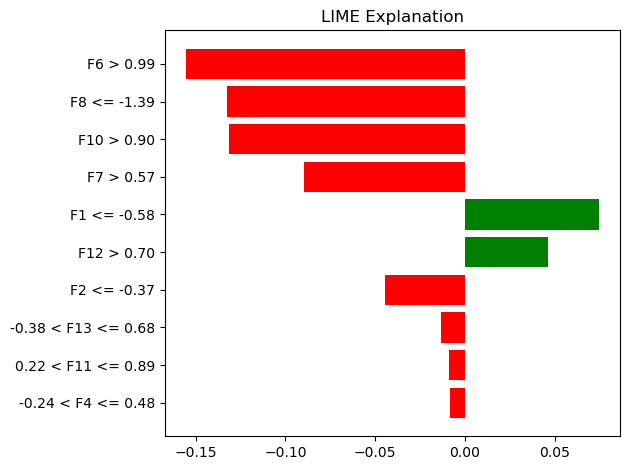

In [50]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# Create LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Choose a test sample to explain
sample_idx = 0
sample = X_test[sample_idx]
true_label = y_test[sample_idx]

# Generate explanation
lime_exp = lime_explainer.explain_instance(
    data_row=sample,
    predict_fn=ensemble.predict_proba,
    num_features=10
)

# Show result
print(f"True label: {class_names[true_label]}")
lime_exp.show_in_notebook()
lime_exp.as_pyplot_figure()
plt.title("LIME Explanation")
plt.tight_layout()
plt.show()


c:\Users\Muhammad Umar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

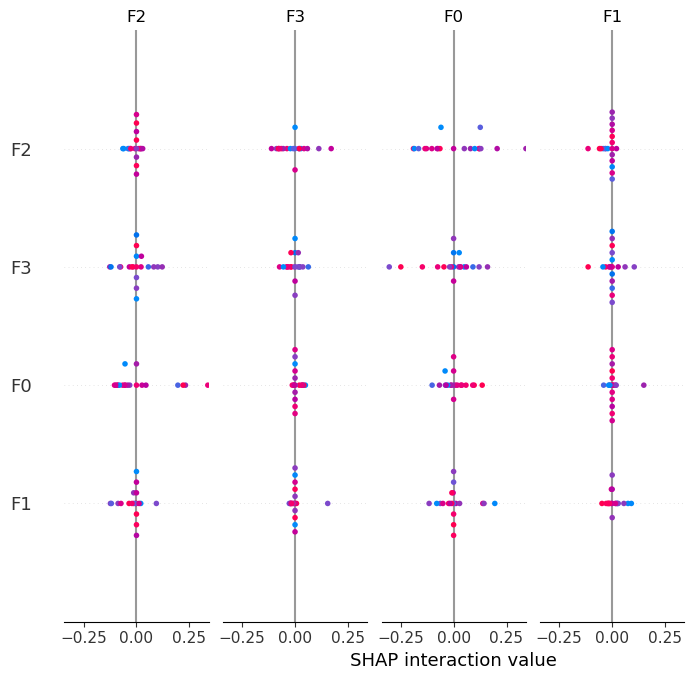

In [51]:
import shap

# KernelExplainer is model-agnostic
explainer = shap.KernelExplainer(ensemble.predict_proba, shap.kmeans(X_train, 10))

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_test[:20], nsamples=100)

# Summary plot
shap.summary_plot(shap_values, features=X_test[:20], feature_names=feature_names)


c:\Users\Muhammad Umar\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


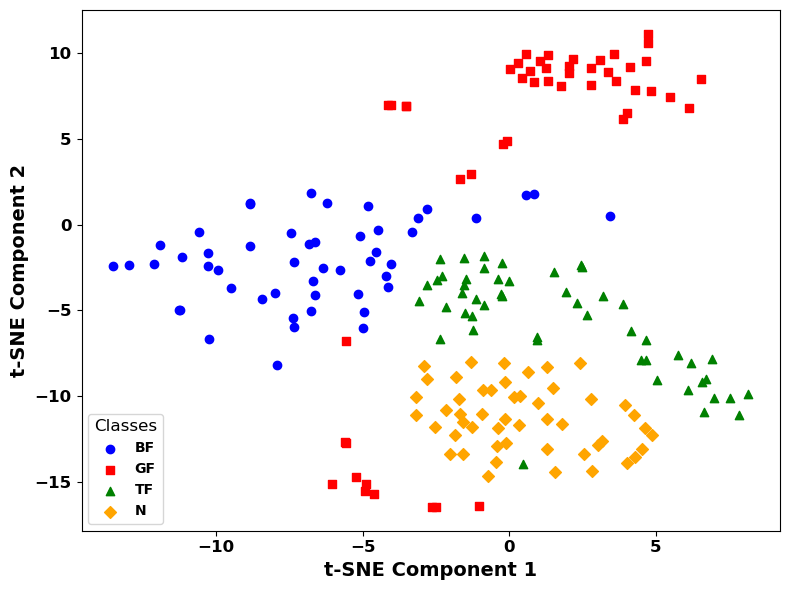

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ====== STEP 1: Standardize features ======
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_latent)

# ====== STEP 2: Apply PCA (up to num_features) ======
n_features = X_scaled.shape[1]
n_pca_components = min(n_features, 15)  # Use 15 or fewer
pca = PCA(n_components=n_pca_components)
X_pca = pca.fit_transform(X_scaled)

# ====== STEP 3: t-SNE with tuned params ======
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1500,
    init='pca',
    random_state=52
)
tsne_results = tsne.fit_transform(X_pca)

# ====== STEP 4: Plotting ======
tsne_labels = y_encoded
class_names = ['BF', 'GF', 'TF', 'N']
markers = ['o', 's', '^', 'D']
colors = ['blue', 'red', 'green', 'orange']

plt.figure(figsize=(8, 6))
for class_idx, (class_name, marker, color) in enumerate(zip(class_names, markers, colors)):
    mask = (tsne_labels == class_idx)
    plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1],
                marker=marker, color=color, label=class_name, alpha=1)

plt.legend(title="Classes", loc='lower left', prop={'weight': 'bold'}, fontsize=10, title_fontsize='12')
plt.xlabel('t-SNE Component 1', fontsize=14, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


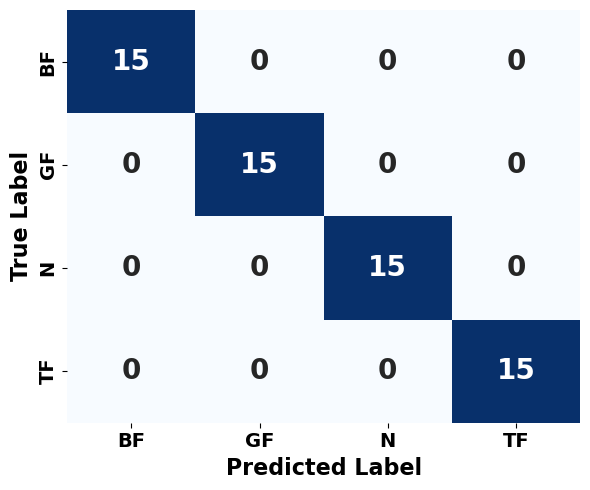

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Define class labels (decoded)
class_labels = label_encoder.classes_

# Plot styled confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar=False, annot_kws={"size": 20, "fontweight": "bold"})

# Axis labels and styling
plt.xlabel('Predicted Label', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
